# Notebook de modèles neuronaux pour CIFAR10

**Librairies**

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.utils import to_categorical, plot_model
from keras.preprocessing import image
import matplotlib.pyplot as plt
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input, decode_predictions
import time

**Versions de librairies**

In [13]:
import sys
print(f"Python {sys.version}")
print(f"Keras Version: {keras.__version__}")
print(f"TensorFlow Version: {tf.__version__}")
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Python 3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)]
Keras Version: 2.10.0
TensorFlow Version: 2.10.0
Num GPUs Available:  0


## CIFAR10

**Lecture des données**

In [14]:
from keras.datasets import cifar10
# Load the data and split it between train and test sets
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print("x_train type:", type(x_train))
print("x_train shape:", x_train.shape)
print("x_test shape:", x_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)
input_shape = (x_train.shape[1],x_train.shape[2],3)
num_classes = len(np.unique(y_train))

x_train type: <class 'numpy.ndarray'>
x_train shape: (50000, 32, 32, 3)
x_test shape: (10000, 32, 32, 3)
y_train shape: (50000, 1)
y_test shape: (10000, 1)


**Affichage des images**

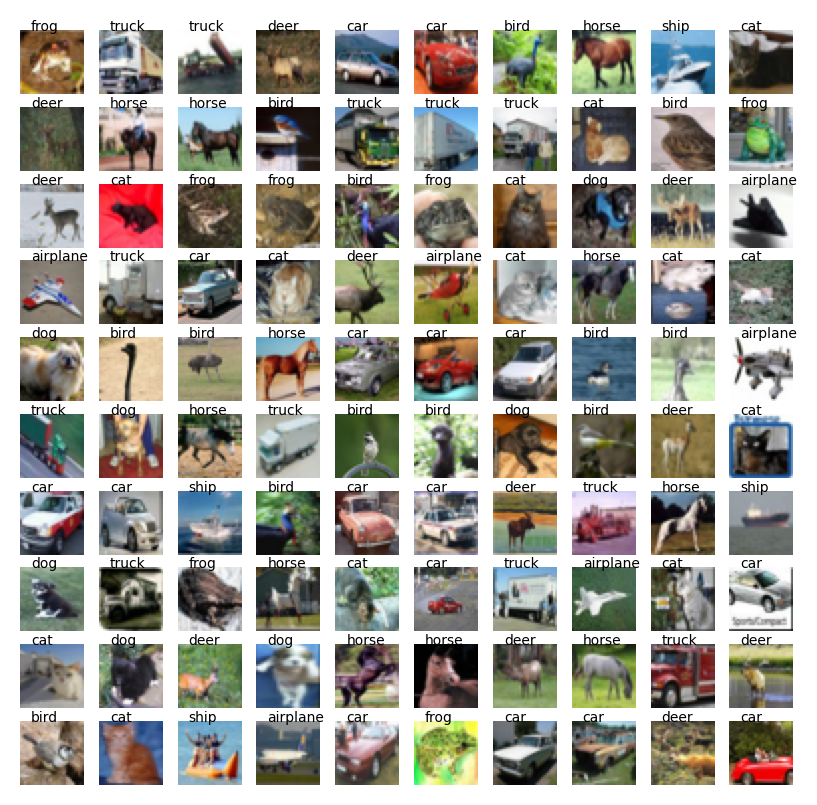

In [15]:
# étiquettes des images CIFAR10
class_names = ["airplane", "car", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

plt.figure(figsize=(5,5), dpi=200)
for i in range(100):
  plt.subplot(10,10,i+1)
  plt.imshow(x_train[i,:])
  label=class_names[int(y_train[i])]
  plt.text(5, 0, label, fontsize=5)
  #plt.title(label, fontsize=5)
  plt.axis('off')
plt.show()

**Préparation des données**

In [16]:
# Scale images to the [0, 1] range
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255
#mean=np.mean(x_train)
#std=np.std(x_train)
#x_train=(x_train-mean)/std
#x_test=(x_test-mean)/std
# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
print("y_train shape:", y_train.shape)

y_train shape: (50000, 10)


In [17]:
# exemple cours (4 couches de convolution)
# https://keras.io/api/layers/
model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3,3), padding="same", activation="relu"),
        layers.Conv2D(32, kernel_size=(3,3), padding="valid", activation="relu"),
        layers.MaxPooling2D(pool_size=(2,2)),
        layers.Dropout(0.2, seed=235),
        layers.Conv2D(32, kernel_size=(3,3), padding="same", activation="relu"),
        layers.Conv2D(32, kernel_size=(3,3), padding="valid", activation="relu"),
        layers.MaxPooling2D(pool_size=(2,2)),
        layers.Dropout(0.2, seed=235),
        layers.Flatten(),
        layers.Dropout(0.5, seed=235),
        layers.Dense(512, activation="relu"),
        layers.Dense(num_classes, activation="softmax"),
    ]
)
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 conv2d_13 (Conv2D)          (None, 30, 30, 32)        9248      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 15, 15, 32)       0         
 2D)                                                             
                                                                 
 dropout_9 (Dropout)         (None, 15, 15, 32)        0         
                                                                 
 conv2d_14 (Conv2D)          (None, 15, 15, 32)        9248      
                                                                 
 conv2d_15 (Conv2D)          (None, 13, 13, 32)        9248      
                                                      

**Modèle séquentiel Keras à 4 couches de convolution avec normalisation batch**

In [22]:
# exemple cours
# https://keras.io/api/layers/
#from tensorflow.keras.layers import Dense, BatchNormalization
model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3,3), padding="same"),
        layers.BatchNormalization(),
        layers.Activation("relu"),
        layers.Conv2D(32, kernel_size=(3,3), padding="valid"),
        layers.BatchNormalization(),
        layers.Activation("relu"),
        layers.MaxPooling2D(pool_size=(2,2)),
        layers.Dropout(0.2, seed=235),
        layers.Conv2D(32, kernel_size=(3,3), padding="same"),
        layers.BatchNormalization(),
        layers.Activation("relu"),
        layers.Conv2D(32, kernel_size=(3,3), padding="valid"),
        layers.BatchNormalization(),
        layers.Activation("relu"),
        layers.MaxPooling2D(pool_size=(2,2)),
        layers.Dropout(0.2, seed=235),
        layers.Flatten(),
        layers.Dropout(0.5, seed=235),
        layers.Dense(512),
        layers.BatchNormalization(),
        layers.Activation("relu"),
        layers.Dense(num_classes, activation="softmax"),
    ]
)
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 32)       128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 32, 32, 32)        0         
                                                                 
 conv2d_17 (Conv2D)          (None, 30, 30, 32)        9248      
                                                                 
 batch_normalization_1 (Batc  (None, 30, 30, 32)       128       
 hNormalization)                                                 
                                                                 
 activation_1 (Activation)   (None, 30, 30, 32)       

**Modèle séquentiel Keras à 6 couches de convolution avec normalisation batch**

In [22]:
model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(64, kernel_size=(3,3), padding="same"),
        layers.BatchNormalization(),
        layers.Activation("relu"),
        layers.Conv2D(64, kernel_size=(3,3), padding="valid"),
        layers.BatchNormalization(),
        layers.Activation("relu"),
        layers.MaxPooling2D(pool_size=(2,2)),
        layers.Dropout(0.2, seed=235),
        layers.Conv2D(128, kernel_size=(3,3), padding="same"),
        layers.BatchNormalization(),
        layers.Activation("relu"),
        layers.Conv2D(128, kernel_size=(3,3), padding="valid"),
        layers.BatchNormalization(),
        layers.Activation("relu"),
        layers.MaxPooling2D(pool_size=(2,2)),
        layers.Dropout(0.2, seed=235),
        layers.Conv2D(256, kernel_size=(3,3), padding="same"),
        layers.BatchNormalization(),
        layers.Activation("relu"),
        layers.Conv2D(256, kernel_size=(3,3), padding="valid"),
        layers.BatchNormalization(),
        layers.Activation("relu"),
        layers.MaxPooling2D(pool_size=(2,2)),
        layers.Dropout(0.2, seed=235),
        layers.Flatten(),
        layers.Dropout(0.5, seed=235),
        layers.Dense(512),
        layers.BatchNormalization(),
        layers.Activation("relu"),
        layers.Dropout(0.5, seed=235),
        layers.Dense(512),
        layers.BatchNormalization(),
        layers.Activation("relu"),
        layers.Dense(num_classes, activation="softmax"),
    ]
)
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 32, 32, 64)        1792      
                                                                 
 batch_normalization_5 (Batc  (None, 32, 32, 64)       256       
 hNormalization)                                                 
                                                                 
 activation_5 (Activation)   (None, 32, 32, 64)        0         
                                                                 
 conv2d_9 (Conv2D)           (None, 30, 30, 64)        36928     
                                                                 
 batch_normalization_6 (Batc  (None, 30, 30, 64)       256       
 hNormalization)                                                 
                                                                 
 activation_6 (Activation)   (None, 30, 30, 64)       

## Augmentation de données

In [36]:
from keras.preprocessing.image import ImageDataGenerator

# set up image augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
    #zoom_range=0.3
    )
datagen.fit(x_train)

In [10]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
    rotation_range=10,
    horizontal_flip=False,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15
    )
datagen.fit(x_train)

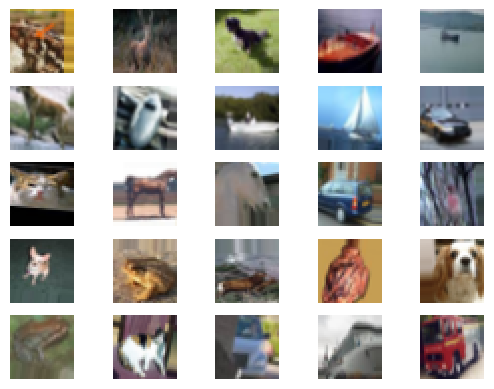

In [11]:
# see augmentation images
#plt.figure(figsize=(10,10), dpi=50)
for X_batch, y_batch in datagen.flow(x_train, y_train, batch_size=25):
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.imshow(X_batch[i])
        plt.axis('off')
    plt.show()
    break

## Apprentissage des modèles

**Apprentissage sans augmentation de données**

batch_size : taille des lots

In [23]:
model.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.RMSprop(learning_rate=1e-3, decay=1e-3), metrics=["accuracy"])
#model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
start_time = time.time()
history=model.fit(x_train, y_train, validation_data=(x_test,y_test), batch_size=64, epochs=20)
print("Temps de calcul :", time.time() - start_time)

Epoch 1/20
782/782 [==============================] - 88s 108ms/step - loss: 1.4275 - accuracy: 0.4896 - val_loss: 1.2406 - val_accuracy: 0.5469
Epoch 2/20
782/782 [==============================] - 84s 107ms/step - loss: 1.0685 - accuracy: 0.6202 - val_loss: 1.3261 - val_accuracy: 0.5454
Epoch 3/20
782/782 [==============================] - 87s 111ms/step - loss: 0.9471 - accuracy: 0.6637 - val_loss: 1.0175 - val_accuracy: 0.6395
Epoch 4/20
782/782 [==============================] - 92s 117ms/step - loss: 0.8781 - accuracy: 0.6921 - val_loss: 1.0153 - val_accuracy: 0.6236
Epoch 5/20
782/782 [==============================] - 88s 112ms/step - loss: 0.8297 - accuracy: 0.7084 - val_loss: 0.8846 - val_accuracy: 0.6901
Epoch 6/20
782/782 [==============================] - 88s 113ms/step - loss: 0.7954 - accuracy: 0.7189 - val_loss: 0.9306 - val_accuracy: 0.6710
Epoch 7/20
782/782 [==============================] - 93s 120ms/step - loss: 0.7724 - accuracy: 0.7299 - val_loss: 0.8700 - val_ac

**Apprentissage avec augmentation de données**

In [42]:
# https://github.com/moritzhambach/Image-Augmentation-in-Keras-CIFAR-10-/blob/master/CNN%20with%20Image%20Augmentation%20(CIFAR10).ipynb

model.compile(loss="categorical_crossentropy", optimizer="rmsprop", metrics=["accuracy"])
start_time = time.time()
history=model.fit_generator(datagen.flow(x_train, y_train, batch_size=128),
                    steps_per_epoch = len(x_train)/128, epochs=10, validation_data=(x_test, y_test))
print("Temps de calcul :", time.time() - start_time)

Epoch 1/10
391/390 [==============================] - 145s 371ms/step - loss: 0.8144 - accuracy: 0.7139 - val_loss: 0.7505 - val_accuracy: 0.7379
Epoch 2/10
391/390 [==============================] - 133s 340ms/step - loss: 0.7952 - accuracy: 0.7185 - val_loss: 0.9239 - val_accuracy: 0.6669
Epoch 3/10
391/390 [==============================] - 125s 319ms/step - loss: 0.7800 - accuracy: 0.7265 - val_loss: 0.7287 - val_accuracy: 0.7571
Epoch 4/10
391/390 [==============================] - 127s 324ms/step - loss: 0.7740 - accuracy: 0.7270 - val_loss: 0.7692 - val_accuracy: 0.7289
Epoch 5/10
391/390 [==============================] - 153s 392ms/step - loss: 0.7569 - accuracy: 0.7328 - val_loss: 0.8950 - val_accuracy: 0.6887
Epoch 6/10
391/390 [==============================] - 126s 322ms/step - loss: 0.7441 - accuracy: 0.7401 - val_loss: 1.0780 - val_accuracy: 0.6267
Epoch 7/10
391/390 [==============================] - 130s 333ms/step - loss: 0.7442 - accuracy: 0.7390 - val_loss: 0.8311 -

**Apprentissage avec early stopping**

In [23]:
from tensorflow.keras.callbacks import EarlyStopping

model.compile(loss="categorical_crossentropy", optimizer="rmsprop", metrics=["accuracy"])
es = EarlyStopping(monitor='val_accuracy', mode='max', patience=10,  restore_best_weights=True)
start_time = time.time()
history=model.fit(x_train, y_train, validation_data=(x_test,y_test), batch_size=128, epochs=20, callbacks=[es])
print("Temps de calcul :", time.time() - start_time)

Epoch 1/20
391/391 [==============================] - 116s 297ms/step - loss: 0.3544 - accuracy: 0.8739 - val_loss: 0.6571 - val_accuracy: 0.7790
Epoch 2/20
391/391 [==============================] - 116s 296ms/step - loss: 0.3540 - accuracy: 0.8754 - val_loss: 0.6504 - val_accuracy: 0.7843
Epoch 3/20
391/391 [==============================] - 119s 305ms/step - loss: 0.3446 - accuracy: 0.8772 - val_loss: 0.6571 - val_accuracy: 0.7657
Epoch 4/20
391/391 [==============================] - 117s 299ms/step - loss: 0.3395 - accuracy: 0.8822 - val_loss: 0.6375 - val_accuracy: 0.7822
Epoch 5/20
391/391 [==============================] - 116s 296ms/step - loss: 0.3368 - accuracy: 0.8820 - val_loss: 0.6714 - val_accuracy: 0.7702
Epoch 6/20
391/391 [==============================] - 116s 296ms/step - loss: 0.3300 - accuracy: 0.8848 - val_loss: 0.6256 - val_accuracy: 0.7843
Epoch 7/20
391/391 [==============================] - 116s 296ms/step - loss: 0.3320 - accuracy: 0.8828 - val_loss: 0.6597 -

**Evaluation du modèle**

In [19]:
loss, acc = model.evaluate(x_test, y_test, verbose=0)
print("Test loss: %.5f" % loss)
print("Test accuracy: %.2f%%" % (100.0 * acc))
print("Error rate: %.2f%%" % (100.0 * (1-acc)))

Test loss: 0.74573
Test accuracy: 75.25%
Error rate: 24.75%


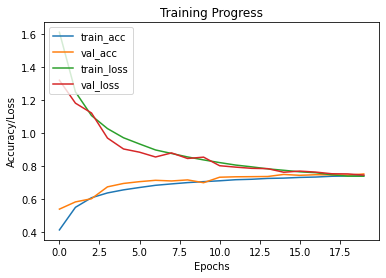

In [20]:
def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.plot(hist.history["loss"])
    plt.plot(hist.history["val_loss"])
    plt.title("Training Progress")
    plt.ylabel("Accuracy/Loss")
    plt.xlabel("Epochs")
    plt.legend(["train_acc", "val_acc", "train_loss", "val_loss"], loc="upper left")
    plt.show()
plot_hist(history)

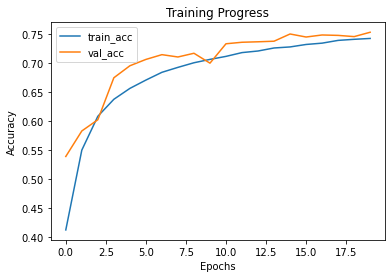

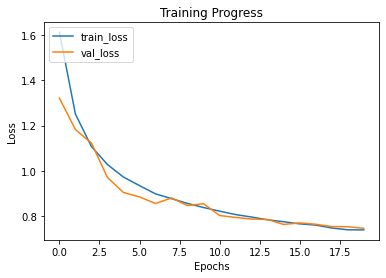

In [21]:
def plot_hist_acc(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title("Training Progress")
    plt.ylabel("Accuracy")
    plt.xlabel("Epochs")
    plt.legend(["train_acc", "val_acc"], loc="upper left")
    plt.show()
def plot_hist_loss(hist):
    plt.plot(hist.history["loss"])
    plt.plot(hist.history["val_loss"])
    plt.title("Training Progress")
    plt.ylabel("Loss")
    plt.xlabel("Epochs")
    plt.legend(["train_loss", "val_loss"], loc="upper left")
    plt.show()
plot_hist_acc(history)
plot_hist_loss(history)

**Prédictions**

In [35]:
predictions = model.predict(x_test)
import pandas as pd
pd.crosstab(np.argmax(y_test, axis=1), np.argmax(predictions, axis=1), margins=True, margins_name="Total" )

313/313 [==============================] - 3s 9ms/step


col_0,0,1,2,3,4,5,6,7,8,9,Total
row_0,,,,,,,,,,,
0,913,3,21,11,9,1,4,1,28,9,1000
1,6,945,0,2,2,1,2,1,14,27,1000
2,38,0,829,39,38,23,19,10,4,0,1000
3,12,1,29,834,22,62,23,8,5,4,1000
4,5,0,20,23,919,8,12,10,3,0,1000
5,6,1,16,108,26,822,5,13,2,1,1000
6,7,0,14,38,12,3,923,2,1,0,1000
7,8,0,5,21,28,24,2,911,1,0,1000
8,24,8,2,5,2,1,3,0,946,9,1000


**Erreurs de prédiction**

In [36]:
errors = list()
for i in range(len(y_test)):
    if np.argmax(y_test, axis=1)[i] != np.argmax(predictions, axis=1)[i]:
        errors.append(i)
len(errors)

1031

**Affichage des 100 premières images mal prédites**

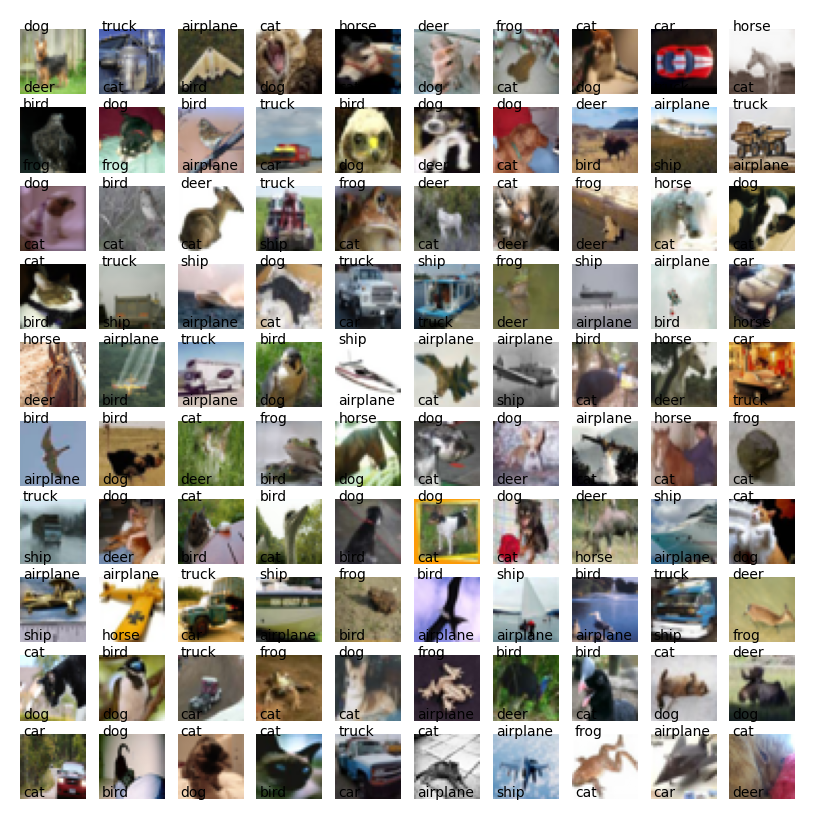

In [37]:
class_names = ["airplane", "car", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]
plt.figure(figsize=(5,5), dpi=200)
for i in range(100):
  plt.subplot(10,10,i+1)
  plt.imshow(x_test[errors[i],:])
  label=class_names[np.argmax(y_test[errors[i]], axis=0)]
  plt.text(1, 0, label, fontsize=5)
  label=class_names[np.argmax(predictions[errors[i]], axis=0)]
  plt.text(1, 30, label, fontsize=5)
  plt.axis('off')
plt.show()

## Apprentissage par transfert

**Modèle préentraîné**

In [6]:
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input

# Loading VGG16 model
base_model = VGG16(weights="imagenet", include_top=False, input_shape=(32,32,3))
# on précise la taille des images CIFAR auxquelles sera appliqué VGG16
#base_model = VGG16(weights="imagenet", include_top=False)
base_model.trainable = False
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0     

In [7]:
model = keras.Sequential(
    [
        keras.Input(shape=(32,32,3)),
        base_model,
        layers.Flatten(),
        layers.Dropout(0.5, seed=235),
        layers.Dense(256),
        layers.BatchNormalization(),
        layers.Dense(128),
        layers.BatchNormalization(),
        layers.Activation("relu"),
        layers.Dense(10, activation="softmax"),
    ]
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 256)               131328    
                                                                 
 batch_normalization (BatchN  (None, 256)              1024      
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                        

In [8]:
from tensorflow.keras.callbacks import EarlyStopping

model.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.RMSprop(learning_rate=1e-3), metrics=["accuracy"])
#model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
es = EarlyStopping(monitor='val_accuracy', mode='max', patience=10,  restore_best_weights=True)
start_time = time.time()
history=model.fit(x_train, y_train, validation_data=(x_test,y_test), batch_size=64, epochs=20, callbacks=[es])
print("Temps de calcul :", time.time() - start_time)

Epoch 1/20
782/782 [==============================] - 81s 56ms/step - loss: 1.6542 - accuracy: 0.4149 - val_loss: 1.3948 - val_accuracy: 0.5067
Epoch 2/20
782/782 [==============================] - 30s 38ms/step - loss: 1.5447 - accuracy: 0.4538 - val_loss: 1.3522 - val_accuracy: 0.5270
Epoch 3/20
782/782 [==============================] - 31s 40ms/step - loss: 1.5021 - accuracy: 0.4685 - val_loss: 1.3236 - val_accuracy: 0.5397
Epoch 4/20
782/782 [==============================] - 32s 41ms/step - loss: 1.4842 - accuracy: 0.4747 - val_loss: 1.3056 - val_accuracy: 0.5444
Epoch 5/20
782/782 [==============================] - 32s 41ms/step - loss: 1.4655 - accuracy: 0.4815 - val_loss: 1.3053 - val_accuracy: 0.5424
Epoch 6/20
782/782 [==============================] - 32s 41ms/step - loss: 1.4525 - accuracy: 0.4872 - val_loss: 1.2927 - val_accuracy: 0.5467
Epoch 7/20
782/782 [==============================] - 32s 41ms/step - loss: 1.4409 - accuracy: 0.4923 - val_loss: 1.2805 - val_accuracy:

**Evaluation du modèle**

In [9]:
loss, acc = model.evaluate(x_test, y_test, verbose=0)
print("Test loss: %.5f" % loss)
print("Test accuracy: %.2f%%" % (100.0 * acc))
print("Error rate: %.2f%%" % (100.0 * (1-acc)))

Test loss: 1.21983
Test accuracy: 57.43%
Error rate: 42.57%


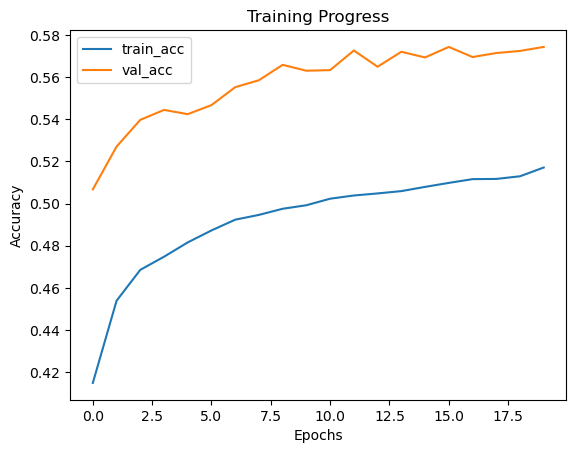

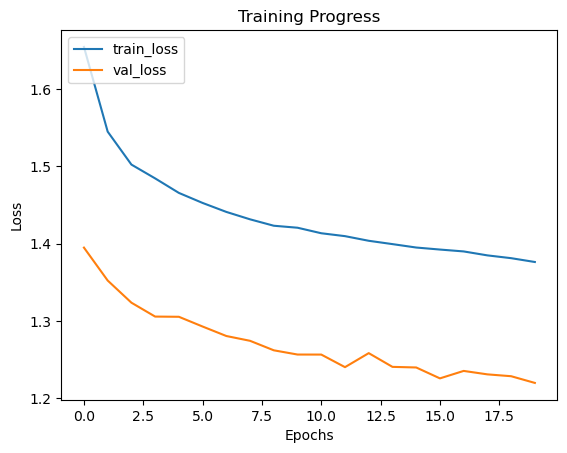

In [10]:
def plot_hist_acc(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title("Training Progress")
    plt.ylabel("Accuracy")
    plt.xlabel("Epochs")
    plt.legend(["train_acc", "val_acc"], loc="upper left")
    plt.show()
def plot_hist_loss(hist):
    plt.plot(hist.history["loss"])
    plt.plot(hist.history["val_loss"])
    plt.title("Training Progress")
    plt.ylabel("Loss")
    plt.xlabel("Epochs")
    plt.legend(["train_loss", "val_loss"], loc="upper left")
    plt.show()
plot_hist_acc(history)
plot_hist_loss(history)

**Liste des objets de la session**

In [10]:
%whos

Variable             Type          Data/Info
--------------------------------------------
VGG16                function      <function VGG16 at 0x0000026E3920BB80>
acc                  float         0.7680000066757202
cifar10              module        <module 'keras.datasets.c<...>s\\datasets\\cifar10.py'>
class_names          list          n=10
decode_predictions   function      <function decode_predicti<...>ns at 0x0000026E3920BCA0>
history              History       <keras.callbacks.History <...>ct at 0x0000026E49BB06D0>
i                    int           99
image                module        <module 'keras.preprocess<...>preprocessing\\image.py'>
input_shape          tuple         n=3
keras                module        <module 'keras.api._v2.ke<...>_v2\\keras\\__init__.py'>
label                str           car
layers               module        <module 'keras.api._v2.ke<...>as\\layers\\__init__.py'>
loss                 float         0.7514646649360657
model                Seque